In [42]:
#library(RJDBC)
library(dplyr)
library(data.table)
library(GeoexperimentsResearch)
library(ggplot2)
library(zoo)
library(scales)
library(googleCloudStorageR)
library(bigrquery)

In [43]:
# sql for model data here https://github.com/tamikanormil/data-and-stuff/tree/main/gda_inc_test_q3

dat <- read.csv(file = 'design_data_tbr_09_25.csv')

colnames(dat)[4]<-c('geo.group')
dat[is.na(dat)] <- 0
dat$date <- as.Date(dat$date,format = "%Y-%m-%d")

dat=dat[dat$date>="2023-01-01",]
dat=dat[dat$date<="2023-08-01",]

,estimate,precision,lower,upper,se,level,thres,prob,model
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
incremental,-234883.1,69523.68,-304406.8,Inf,53093.25,0.9,0,0,tbr1


Warning message:
“Removed 134 rows containing missing values (`geom_line()`).”


,estimate,precision,lower,upper,level,incr.resp,incr.cost,thres,prob,model
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
iROAS,2.178156,0.6666928,1.511463,Inf,0.9,-234883.1,-108074.9,0,1,tbr1


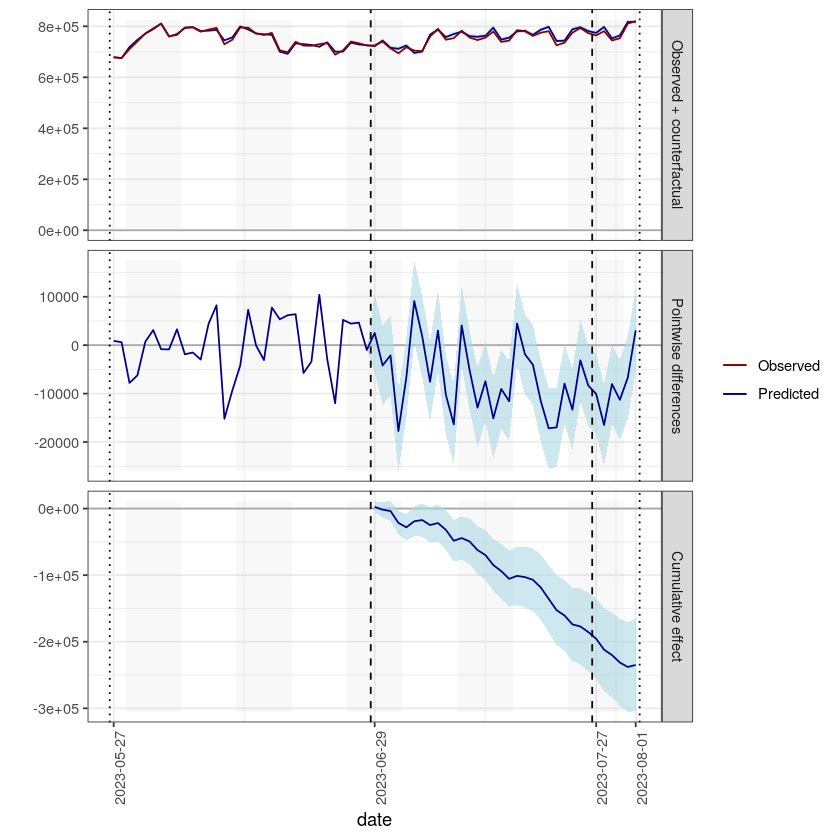

In [45]:
#CUPED + COVARIANTS // LOW ROAS geos excluded from data set

model_dat<-dat

theta_coef_full_buyers<-lm(formula = response ~ agg_buyers, data = model_dat)$coefficients['agg_buyers']

model_dat$cuped_revenue <-model_dat$response-(theta_coef_full_buyers*((model_dat$agg_buyers-mean(model_dat$agg_buyers))))      
                                                      
model_dat <- model_dat[,c('date','geo','geo.group','cost','cuped_revenue','agg_buyers')]

model_dat = model_dat[which(!model_dat$geo %in% c(517, 533, 535)),]

obj.per2 <- ExperimentPeriods(c("2023-05-27","2023-06-29","2023-07-27","2023-08-01"))

obj.gts2 <- GeoTimeseries(model_dat, metrics=c("cost", 'cuped_revenue'))
# 'sem_b_cost','sem_nb_cost', 'gda_cost'
obj.ga2 <- GeoAssignment(unique(model_dat[,c(2,3)]))
obj2 <- GeoExperimentData(obj.gts2,
                         periods=obj.per2,
                         geo.assignment=obj.ga2)

obj.tbr.roas2 <- DoTBRROASAnalysis(obj2, response='cuped_revenue', cost='cost',
                                  model='tbr1',
                                  pretest.period=c(0),
                                  intervention.period=1,
                                  cooldown.period=c(2),
                                  control.group=1,
                                  treatment.group=2)

obj.tbr <- DoTBRAnalysis(obj2, response='cuped_revenue', cost='cost',
                                  model='tbr1',
                                  pretest.period=c(0),
                                  intervention.period=1,
                                  cooldown.period=c(2),
                                  control.group=1,
                                  treatment.group=2)


summary(obj.tbr)
plot(obj.tbr)
summary(obj.tbr.roas2)

,estimate,precision,lower,upper,se,level,thres,prob,model
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
incremental,-122197.3,71846.78,-194044,Inf,54867.34,0.9,0,0.017,tbr1


Warning message:
“Removed 134 rows containing missing values (`geom_line()`).”


,estimate,precision,lower,upper,level,incr.resp,incr.cost,thres,prob,model
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
iROAS,1.26962,0.7489438,0.5206763,Inf,0.9,-122197.3,-96392.17,0,0.983,tbr1


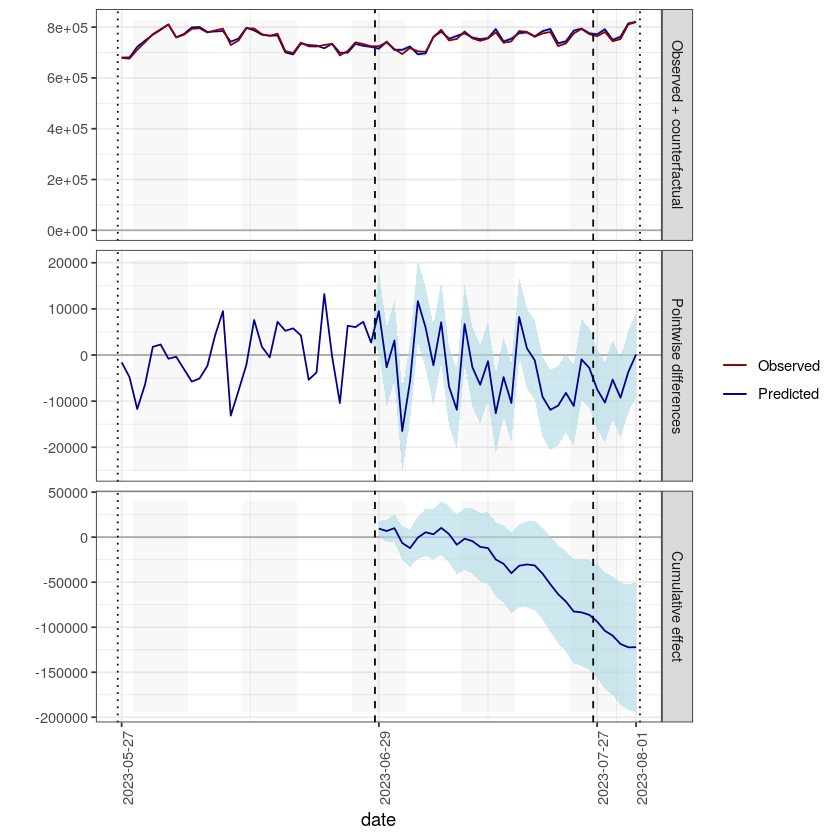

In [54]:
#CUPED + COVARIANTS // LOW ROAS geos included in data set

model_dat<-dat

theta_coef_full_buyers<-lm(formula = response ~ agg_buyers, data = model_dat)$coefficients['agg_buyers']

model_dat$cuped_revenue <-model_dat$response-(theta_coef_full_buyers*((model_dat$agg_buyers-mean(model_dat$agg_buyers))))      
                                                      
model_dat <- model_dat[,c('date','geo','geo.group','cost','cuped_revenue','agg_buyers')]

model_dat = model_dat[which(!model_dat$geo %in% c()),]

obj.per2 <- ExperimentPeriods(c("2023-05-27","2023-06-29","2023-07-27","2023-08-01"))

obj.gts2 <- GeoTimeseries(model_dat, metrics=c("cost", 'cuped_revenue'))
# 'sem_b_cost','sem_nb_cost', 'gda_cost'
obj.ga2 <- GeoAssignment(unique(model_dat[,c(2,3)]))
obj2 <- GeoExperimentData(obj.gts2,
                         periods=obj.per2,
                         geo.assignment=obj.ga2)

obj.tbr.roas2 <- DoTBRROASAnalysis(obj2, response='cuped_revenue', cost='cost',
                                  model='tbr1',
                                  pretest.period=c(0),
                                  intervention.period=1,
                                  cooldown.period=c(2),
                                  control.group=1,
                                  treatment.group=2)

obj.tbr <- DoTBRAnalysis(obj2, response='cuped_revenue', cost='cost',
                                  model='tbr1',
                                  pretest.period=c(0),
                                  intervention.period=1,
                                  cooldown.period=c(2),
                                  control.group=1,
                                  treatment.group=2)


summary(obj.tbr)
plot(obj.tbr)
summary(obj.tbr.roas2)

In [50]:
################### Bootstrap Simulation  ########################

#### Update these with your test inputs ####
preperiod_start<-"2023-05-15"
test_start<-"2023-06-29"
test_end<-"2023-07-27"
cooldown_end<-"2023-08-01"
preperiod_days<-33
test_days<-28
aa_test_start<-"2023-06-29"
aa_test_end<-"2023-07-27"

bootstrap_score <- data.frame(
  iROAS=double(),
  precision=double(),
  incr.resp=double(),
  incr.cost=double(),
  pval=double())
#,corr=double()
#,aa_pval=double()

control_geos <- filter(dat,geo.group==1)$geo
treatment_geos <- filter(dat,geo.group==2)$geo

for (i in 1:20) {
  print(i)
    
  bootstrap_data<-dat[which(!dat$geo %in% c()), c('date','geo','geo.group','cost','response') ]
  #'sem_b_cost', 'sem_nb_cost','gda_cost', 'agg_buyers'
  i=0
   while(TRUE&i<20){
     i=i+1
     control_sample = sample(control_geos,sample(1:length(control_geos),1),replace=TRUE)
     treatment_sample = sample(treatment_geos,sample(1:length(treatment_geos),1),replace=TRUE)
     bootstrap_data$geo.group<-ifelse(bootstrap_data$geo %in% treatment_sample, 1, ifelse(bootstrap_data$geo %in% control_sample, 2, 0))
    }
    
    corr_df = bootstrap_data%>%group_by(date,geo,geo.group)%>%summarise_at(c("response", "cost"), sum, na.rm=TRUE)
    #summarise(response=sum(response))
    #corr_df$geo <- corr_df$geo.group 
    #corr_df$cost <- corr_df$response 
    #two response fields, and then no geos
    
    if (nrow(filter(corr_df,(geo.group==1&date<=test_start)))==nrow(filter(corr_df,(geo.group==2&date<=test_start)))) {
      correlation <- cor(filter(corr_df,(geo.group==1&date<=test_start))$response,filter(corr_df,(geo.group==2&date<=test_start))$response)
      if (correlation >.95) {
        obj.gts_corr <- GeoTimeseries(corr_df, metrics=c("cost", "response")) #'sem_b_cost', 'sem_nb_cost','gda_cost'
        obj.per_corr <- ExperimentPeriods(c(preperiod_start, aa_test_start, aa_test_end))
        ##You might need to change this to be the right columns
        obj.ga_corr <- GeoAssignment(unique(corr_df[,c(2,3)]))
        
        obj_corr <- GeoExperimentData(obj.gts_corr,
                                      periods=obj.per_corr,
                                      geo.assignment=obj.ga_corr)
        obj_corr.tbr <- DoTBRAnalysis(obj_corr, response='response',
                                      cost='cost',
                                      model='tbr1',
                                      pretest.period=c(0),
                                      intervention.period=1,
                                      control.group=1,
                                      treatment.group=2)
        aa_pval <- summary(obj_corr.tbr, level=0.90, interval.type="one-sided")$prob
        if (aa_pval<=.25) {
          #Calculate required impact for 80% power
          n<-preperiod_days
          ntest<-test_days
          corr <- cor(filter(corr_df,(geo.group==1&date<=test_start))$response,filter(corr_df,(geo.group==2&date<=test_start))$response)
          phi<-qf(.9, 1, n-1)
          tq_sig<-qt(.9,n-2)
          tq_pow<-qt(.8,n-2)
          sq<-sqrt(phi * (n + 1) / (n * ntest * (n - 1)) + 1 / n + 1 / ntest)
          term<-(tq_sig + tq_pow) * ntest * sq
          sigma <- sd(filter(corr_df,(geo.group==1&date<=test_start))$response) * sqrt(1-corr**2)
          impact <- term * sigma
          obj.gts_corr <- GeoTimeseries(corr_df, metrics=c("cost", "response")) 
          # 'sem_b_cost', 'sem_nb_cost','gda_cost'
          obj.per_corr <- ExperimentPeriods(c(preperiod_start, test_start, test_end, cooldown_end))
          ##Again you may need to update your columns here to contain geo and geo.group
          obj.ga_corr <- GeoAssignment(unique(corr_df[,c(2,3)]))
          
          obj_corr <- GeoExperimentData(obj.gts_corr,
                                        periods=obj.per_corr,
                                        geo.assignment=obj.ga_corr)
          obj_corr.tbr <- DoTBRAnalysis(obj_corr, response='response',
                                        cost='cost',
                                        model='tbr1',
                                        pretest.period=c(0),
                                        intervention.period=1,
                                        cooldown.period=2,
                                        control.group=1,
                                        treatment.group=2)
          if(abs(summary(obj_corr.tbr, level=0.90, interval.type="one-sided")$estimate)>impact) {
            #if(TRUE) {
            break
          }
        }
      }
    }
  }
  bootstrap_data<-filter(bootstrap_data, geo.group != 0)
  obj.gts_boot <- GeoTimeseries(bootstrap_data, metrics=c("cost", "response")) # 'sem_b_cost', 'sem_nb_cost','gda_cost'
  obj.per_boot <- ExperimentPeriods(c(preperiod_start, test_start, test_end, cooldown_end))
  ##Update to contain the geo and geo.group
  obj.ga_boot <- GeoAssignment(unique(bootstrap_data[,c(2,3)]))
  
  obj_boot <- GeoExperimentData(obj.gts_boot,
                                periods=obj.per_boot,
                                geo.assignment=obj.ga_boot)
  obj.tbr.roas <- DoTBRROASAnalysis(obj_boot, response='response', cost='cost',
                                    model='tbr1',
                                    pretest.period=c(0),
                                    intervention.period=1,
                                    cooldown.period=2,
                                    control.group=1,
                                    treatment.group=2)
  bootstrap_score[nrow(bootstrap_score) + 1,] <- c(summary(obj.tbr.roas)$estimate,summary(obj.tbr.roas)$precision,summary(obj.tbr.roas)$incr.resp,summary(obj.tbr.roas)$incr.cost,summary(obj.tbr.roas)$prob) #, correlation, aapval
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20


In [52]:
print(bootstrap_score)

       iROAS precision incr.resp incr.cost  pval
1  0.6843884 0.6551096  81915.36  119596.8 0.909
2  0.6875242 0.6615585  81915.36  119596.8 0.909
3  0.6843078 0.6550654  81915.36  119596.8 0.909
4  0.6844279 0.6556847  81915.36  119596.8 0.910
5  0.6787060 0.6490322  79491.18  117342.3 0.910
6  0.6844427 0.6531701  81915.36  119596.8 0.910
7  0.6827382 0.6565936  81915.36  119596.8 0.909
8  0.6806646 0.6511895  81915.36  119596.8 0.910
9  0.6832476 0.6595806  81915.36  119596.8 0.908
10 0.6839212 0.6532700  81915.36  119596.8 0.909
11 0.6877215 0.6607535  81915.36  119596.8 0.909
12 0.6890435 0.6568496  81915.36  119596.8 0.910
13 0.6824047 0.6555151  81915.36  119596.8 0.909
14 0.6811602 0.6483218  81915.36  119596.8 0.911
15 0.6836012 0.6582703  81915.36  119596.8 0.908
16 0.6839245 0.6587797  81915.36  119596.8 0.908
17 0.6832426 0.6542353  81915.36  119596.8 0.910
18 0.6868787 0.6561849  81915.36  119596.8 0.910
19 0.6837589 0.6534000  81915.36  119596.8 0.909
20 0.6803575 0.65490

[1] 1.238095

[1] 0.6799402

50% 
1.241966

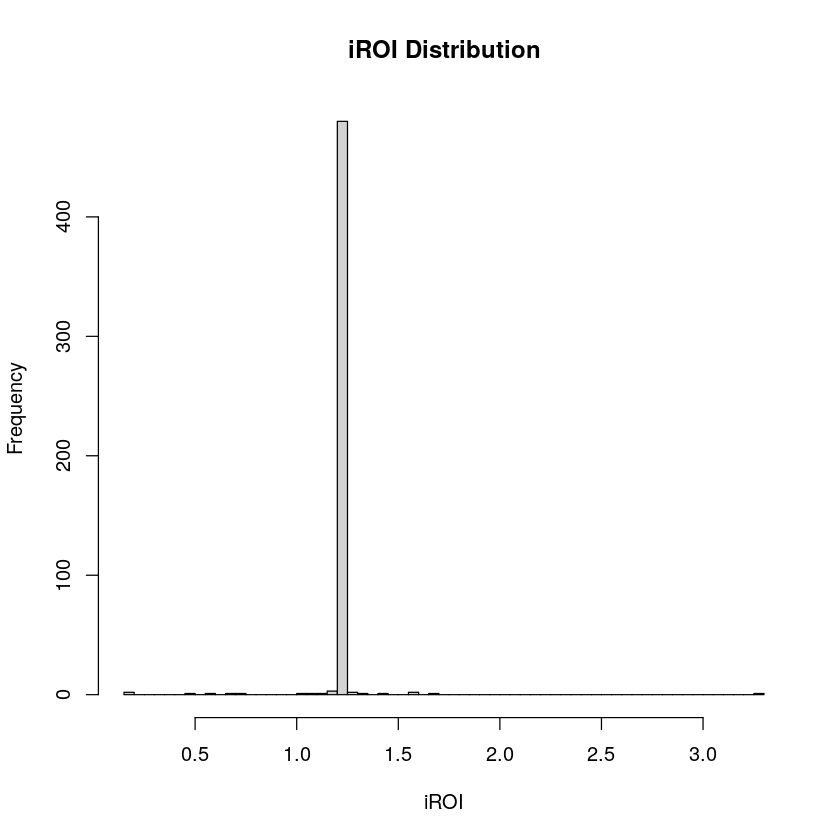

In [49]:
#save to csv
write.csv(bootstrap_score,"bootstrap_score_exclude_no_exclude.csv")
hist(bootstrap_score$iROAS,
     breaks=100,
     main="iROI Distribution",
     xlab="iROI",)
mean(bootstrap_score$iROAS)
mean(bootstrap_score$precision)
bootstrap_cdf <- ecdf(bootstrap_score$iROAS)
#median iROAS

quantile(bootstrap_cdf, .5)

In [41]:
# testing for GEO outliers

dat_no_geo_outlier = dat[which(!dat$geo %in% c()),]

x <- sort(unique(dat_no_geo_outlier$geo))
score <- data.frame(
          geo = double(),
          iROAS=double(),
          precision=double(),
          prob=double())

for(row in x){
dat_loop = dat_no_geo_outlier[dat_no_geo_outlier$geo!=row,]

obj.gts2_loop <- GeoTimeseries(dat_loop, metrics=c("cost", "response"))

obj.per2 <- ExperimentPeriods(c("2023-05-27","2023-06-29","2023-07-27","2023-08-01"))


obj.ga2 <- GeoAssignment(unique(dat_loop[,c(3,4)]))
obj2_loop <- GeoExperimentData(obj.gts2_loop,
                         periods=obj.per2,
                         geo.assignment=obj.ga2)
# result2 <- DoGBRROASAnalysis(obj2_loop, response='response', cost='cost',
#                              pretest.period=c(0,2),
#                             intervention.period= 4,
#                             cooldown.period=5,
#                             control.group=1,
#                             treatment.group=2)
obj.tbr.roas2 <- DoTBRROASAnalysis(obj2_loop, response='response', cost='cost',
                                  model='tbr1',
                                  pretest.period=c(0),
                                  intervention.period=1,
                                  cooldown.period=2,
                                  control.group=1,
                                  treatment.group=2)

score[nrow(score) + 1,] <- c(row,summary(obj.tbr.roas2)$estimate,summary(obj.tbr.roas2)$precision, summary(obj.tbr.roas2)$prob)
}
score

,geo,iROAS,precision,prob
,<dbl>,<dbl>,<dbl>,<dbl>
1,502,1.199435,0.7664898,0.976
2,503,1.287610,0.7432782,0.985
3,507,1.283245,0.7862471,0.980
4,509,1.351003,0.7409150,0.988
5,513,1.373054,0.7561598,0.989
6,514,1.410108,0.7570478,0.990
7,516,1.254755,0.7429042,0.982
8,517,1.595807,0.6952617,0.997
9,519,1.213032,0.7507236,0.980


In [34]:
#get geos where GBR iROAS is outside 2.5 SDs
score$geo[score$iROAS<mean(score$iROAS)-(3*sd(score$iROAS))]
score$geo[score$iROAS>mean(score$iROAS)+(3*sd(score$iROAS))]
score$geo[score$precision<mean(score$precision)-(3*sd(score$precision))]

mean(score$iROAS) 
sd(score$iROAS) 
mean(score$precision)
sd(score$precision)

[1] 523 640

numeric(0)

[1] 535

[1] 2.131538

[1] 0.07610314

[1] 0.7006707

[1] 0.01230077

In [ ]:
score$mean_iROAs <- mean(score$iROAS) 

In [32]:
write.csv(score,"score_exclude_517_533.csv")

In [ ]:
#go back and clean up co variants - use causual impact to estimate predictability 